<a href="https://colab.research.google.com/github/greentfrapp/lucent/blob/master/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<img src="https://raw.githubusercontent.com/greentfrapp/lucent/master/images/lucent_header.jpg" width="600"></img>

# Lucent Tutorial

A Colab notebook following the spirit of Lucid's notebooks.



## Install, Import, Load Model

In [2]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git

!wget -nc https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth

     |████████████████████████████████| 163kB 8.6MB/s 
--2020-05-15 00:58:56--  https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ProGamerGov/pytorch-old-tensorflow-models/master/inception5h.pth [following]
--2020-05-15 00:58:56--  https://raw.githubusercontent.com/ProGamerGov/pytorch-old-tensorflow-models/master/inception5h.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28283262 (27M) [application/octet-stream]
Saving to: ‘inception5h.pth’

inception5h.pth     100%[===================>]  26.97M   118MB/s    in

In [0]:
import torch

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True, modelpath="inception5h.pth")
_ = model.to(device).eval()

Similar to [Lucid](https://github.com/tensorflow/lucid/), this tutorial will be focused on the same InceptionV1 model, also known as GoogLeNet.

Check out the original GoogLeNet paper [here](https://research.google.com/pubs/archive/43022.pdf).

[Distill](https://distill.pub) also has a fascinating [article](https://distill.pub/2017/feature-visualization/) on this topic that includes visualizations of all the InceptionV1 neurons.


## Visualize!

There are fewer defaults built into the `render_vis` function for now, so we have to specify more things.

100%|██████████| 129/129 [00:02<00:00, 50.77it/s]



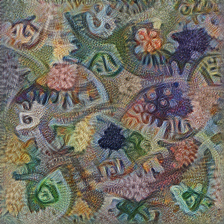

In [5]:
params, image = param.image(224)
scaled_image = lambda: image() * 255 # InceptionV1 takes [0, 255] input
optimizer = torch.optim.Adam(params, lr=5e-2)

_ = render.render_vis(model, "mixed4a:476", scaled_image, optimizer, thresholds=(128,), show_inline=True)

## Fiddling with the Knobs

Just like Lucid, Lucent splits visualizations into *objectives*, *parameterization* and *transforms*. To quote from Lucid's tutorial:

* **Objectives** -- What do you want the model to visualize?
* **Parameterizations** -- How do you describe the image?
* **Transforms** -- What transformations do you want your visualization to be robust to?

### Objectives

What loss function do we want to minimize?

Or from another point of view, what part of the model do we want to understand?

100%|██████████| 129/129 [00:01<00:00, 64.99it/s]



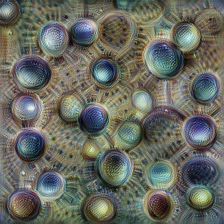

In [6]:
params, image = param.image(224)
scaled_image = lambda: image() * 255
optimizer = torch.optim.Adam(params, lr=5e-2)

# The default is optimizing for a channel/filter
obj = objectives.channel("mixed4a", 465)
_ = render.render_vis(model, obj, scaled_image, optimizer, thresholds=(128,), show_inline=True)

100%|██████████| 129/129 [00:02<00:00, 63.46it/s]



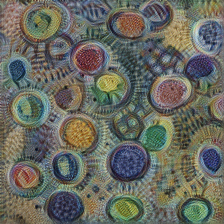

In [7]:
params, image = param.image(224)
scaled_image = lambda: image() * 255
optimizer = torch.optim.Adam(params, lr=5e-2)

# Just like in Lucid, we can sum objectives
channel = lambda n: objectives.channel("mixed4a", n)
obj = channel(476) + channel(465)
_ = render.render_vis(model, obj, scaled_image, optimizer, thresholds=(128,), show_inline=True)

100%|██████████| 129/129 [00:02<00:00, 55.14it/s]



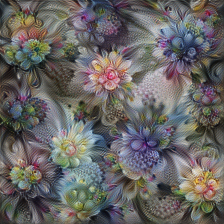

In [8]:
params, image = param.image(224)
scaled_image = lambda: image() * 255
optimizer = torch.optim.Adam(params, lr=5e-2)

# Here's a favorite
_ = render.render_vis(model, "mixed4d_3x3_bottleneck_pre_relu_conv:139", scaled_image, optimizer, thresholds=(128,), show_inline=True)

### Parameterizations

For an initial attempt at feature visualization, we might do gradient descent in the pixel space of a randomly initialized image. Unfortunately, this often creates images comprising high frequency noise, similar to [adversarial images](https://arxiv.org/abs/1312.6199).

Instead, the use of alternative parameterizations can produce more visually intuitive results, by operating in the frequency domain or using compositional pattern producing networks.

Recomended reading: Distill's Feature Visualization article, specifically the section on [Preconditioning and Parameterization](https://distill.pub/2017/feature-visualization/#preconditioning)

In [0]:
# Constant parameters for the next few visualizations
transforms = []
obj = "mixed4d_3x3_bottleneck_pre_relu_conv:139"

def tutorial_vis(obj, params, image, transforms, lr=5e-2, steps=128):
  optimizer = torch.optim.Adam(params, lr=lr)
  _ = render.render_vis(model, obj, image, optimizer, thresholds=(steps,), transforms=transforms, show_inline=True)

100%|██████████| 129/129 [00:02<00:00, 61.84it/s]



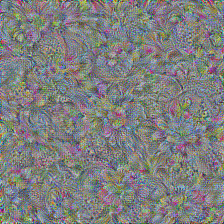

In [10]:
# A visualization with gradient descent in pixel space, notice the similarity to adversarial noise

params, image = param.image(224, fft=False, decorrelate=False)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms)

100%|██████████| 129/129 [00:02<00:00, 56.39it/s]



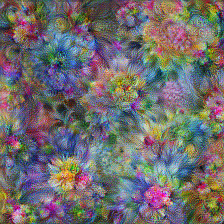

In [11]:
# A visualization with gradient descent in Fourier basis

params, image = param.image(224, fft=True, decorrelate=False)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms)

100%|██████████| 129/129 [00:02<00:00, 55.84it/s]



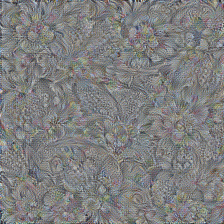

In [12]:
# A visualization with channel decorrelation

params, image = param.image(224, fft=False, decorrelate=True)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms)

100%|██████████| 129/129 [00:02<00:00, 61.98it/s]



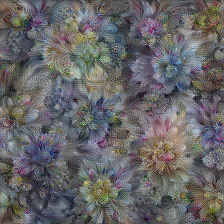

In [13]:
# A visualization with gradient descent in Fourier basis + channel decorrelation

params, image = param.image(224, fft=True, decorrelate=True)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms)

100%|██████████| 513/513 [00:13<00:00, 36.73it/s]



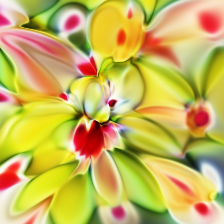

In [14]:
# A visualization with CPPN parameterization

params, image = param.cppn(224)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms, lr=5e-3, steps=512) # learning rate reduced to 5e-3

### Transformations

Another way to reduce high-frequency components in the visualization is by imposing constraints in the form of transformation robustness.

Distill's Feature Visualization article, specifically the section titled [The Enemy of Feature Visualization](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis).

100%|██████████| 129/129 [00:02<00:00, 59.93it/s]



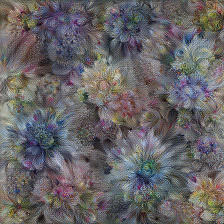

In [15]:
# No transformations, similar to our example earlier

transforms = []

params, image = param.image(224)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms)

100%|██████████| 129/129 [00:02<00:00, 54.43it/s]



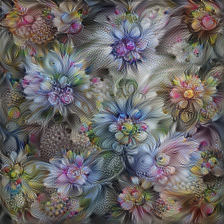

In [16]:
# Adding jitter, notice that the visualization is much less noisy!

transforms = [transform.jitter(8)]

params, image = param.image(224)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms)

100%|██████████| 129/129 [00:03<00:00, 42.53it/s]



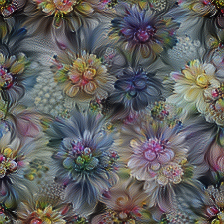

In [17]:
# Adding a whole suite of transforms!

transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(list(range(-10,10)) + list(range(-5,5)) + 10*list(range(-2,2))),
    transform.jitter(2)
]

params, image = param.image(224)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms)

100%|██████████| 513/513 [00:19<00:00, 26.89it/s]



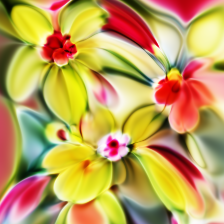

In [18]:
# Adding jitter with CPPN

transforms = [transform.jitter(8)]

params, image = param.cppn(224)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms, lr=5e-3, steps=512)

100%|██████████| 513/513 [00:21<00:00, 23.80it/s]



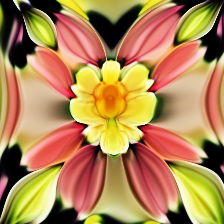

In [19]:
transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(list(range(-10,10)) + list(range(-5,5)) + 10*list(range(-2,2))),
    transform.jitter(2)
]

params, image = param.cppn(224)
scaled_image = lambda: image() * 255
tutorial_vis(obj, params, scaled_image, transforms, lr=5e-3, steps=512)

## Conclusion

And that's it for now!

Credits to the folks at [Lucid](https://github.com/tensorflow/lucid) for doing such a great job at creating the library for Tensorflow!

Also, a big thanks to [ProGamerGov](https://github.com/ProGamerGov) for converting the InceptionV1 model to PyTorch!

If you are interested, do check out the `#proj-lucid` channel on the Distill slack ([join link](http://slack.distill.pub))!